In [208]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt

In [200]:
def position_mapping(df_in):
    all_positions = set()
    df_in['Position List'] = df_in['Position'].apply(lambda x : x.split(', '))
    for positions in df_in['Position List']:
        all_positions.update(positions)
    for pos in sorted(all_positions):
        df_in[pos] = df_in['Position List'].apply(lambda x : 1 if pos in x else 0)
    df_in = df_in.drop(columns = ['Position', 'Position List'])
    return df_in

# Loads FM dataset
data = pd.read_csv("football_manager_data_no_gk.csv")

# Drops unneeded columns
data = data.drop(columns=['Inf', 'Name', 'CA'])
data = data.drop(data.tail(2).index)
#data = position_mapping(data)
data = data.drop(columns = ['Position'])

# Separate features (X) and target (y)
X = data.drop(columns=['PA'])
y = data['PA']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [201]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=200, 
                   learning_rate=0.01, 
                   max_depth=5, 
                   random_state=42,
                   reg_alpha=1,
                   reg_lambda=1)

# Train the model
xgb.fit(X_train, y_train)

# Predict on test data
y_pred = xgb.predict(X_test)

In [202]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Mean Absolute Error: 10.85
Mean Squared Error: 192.04


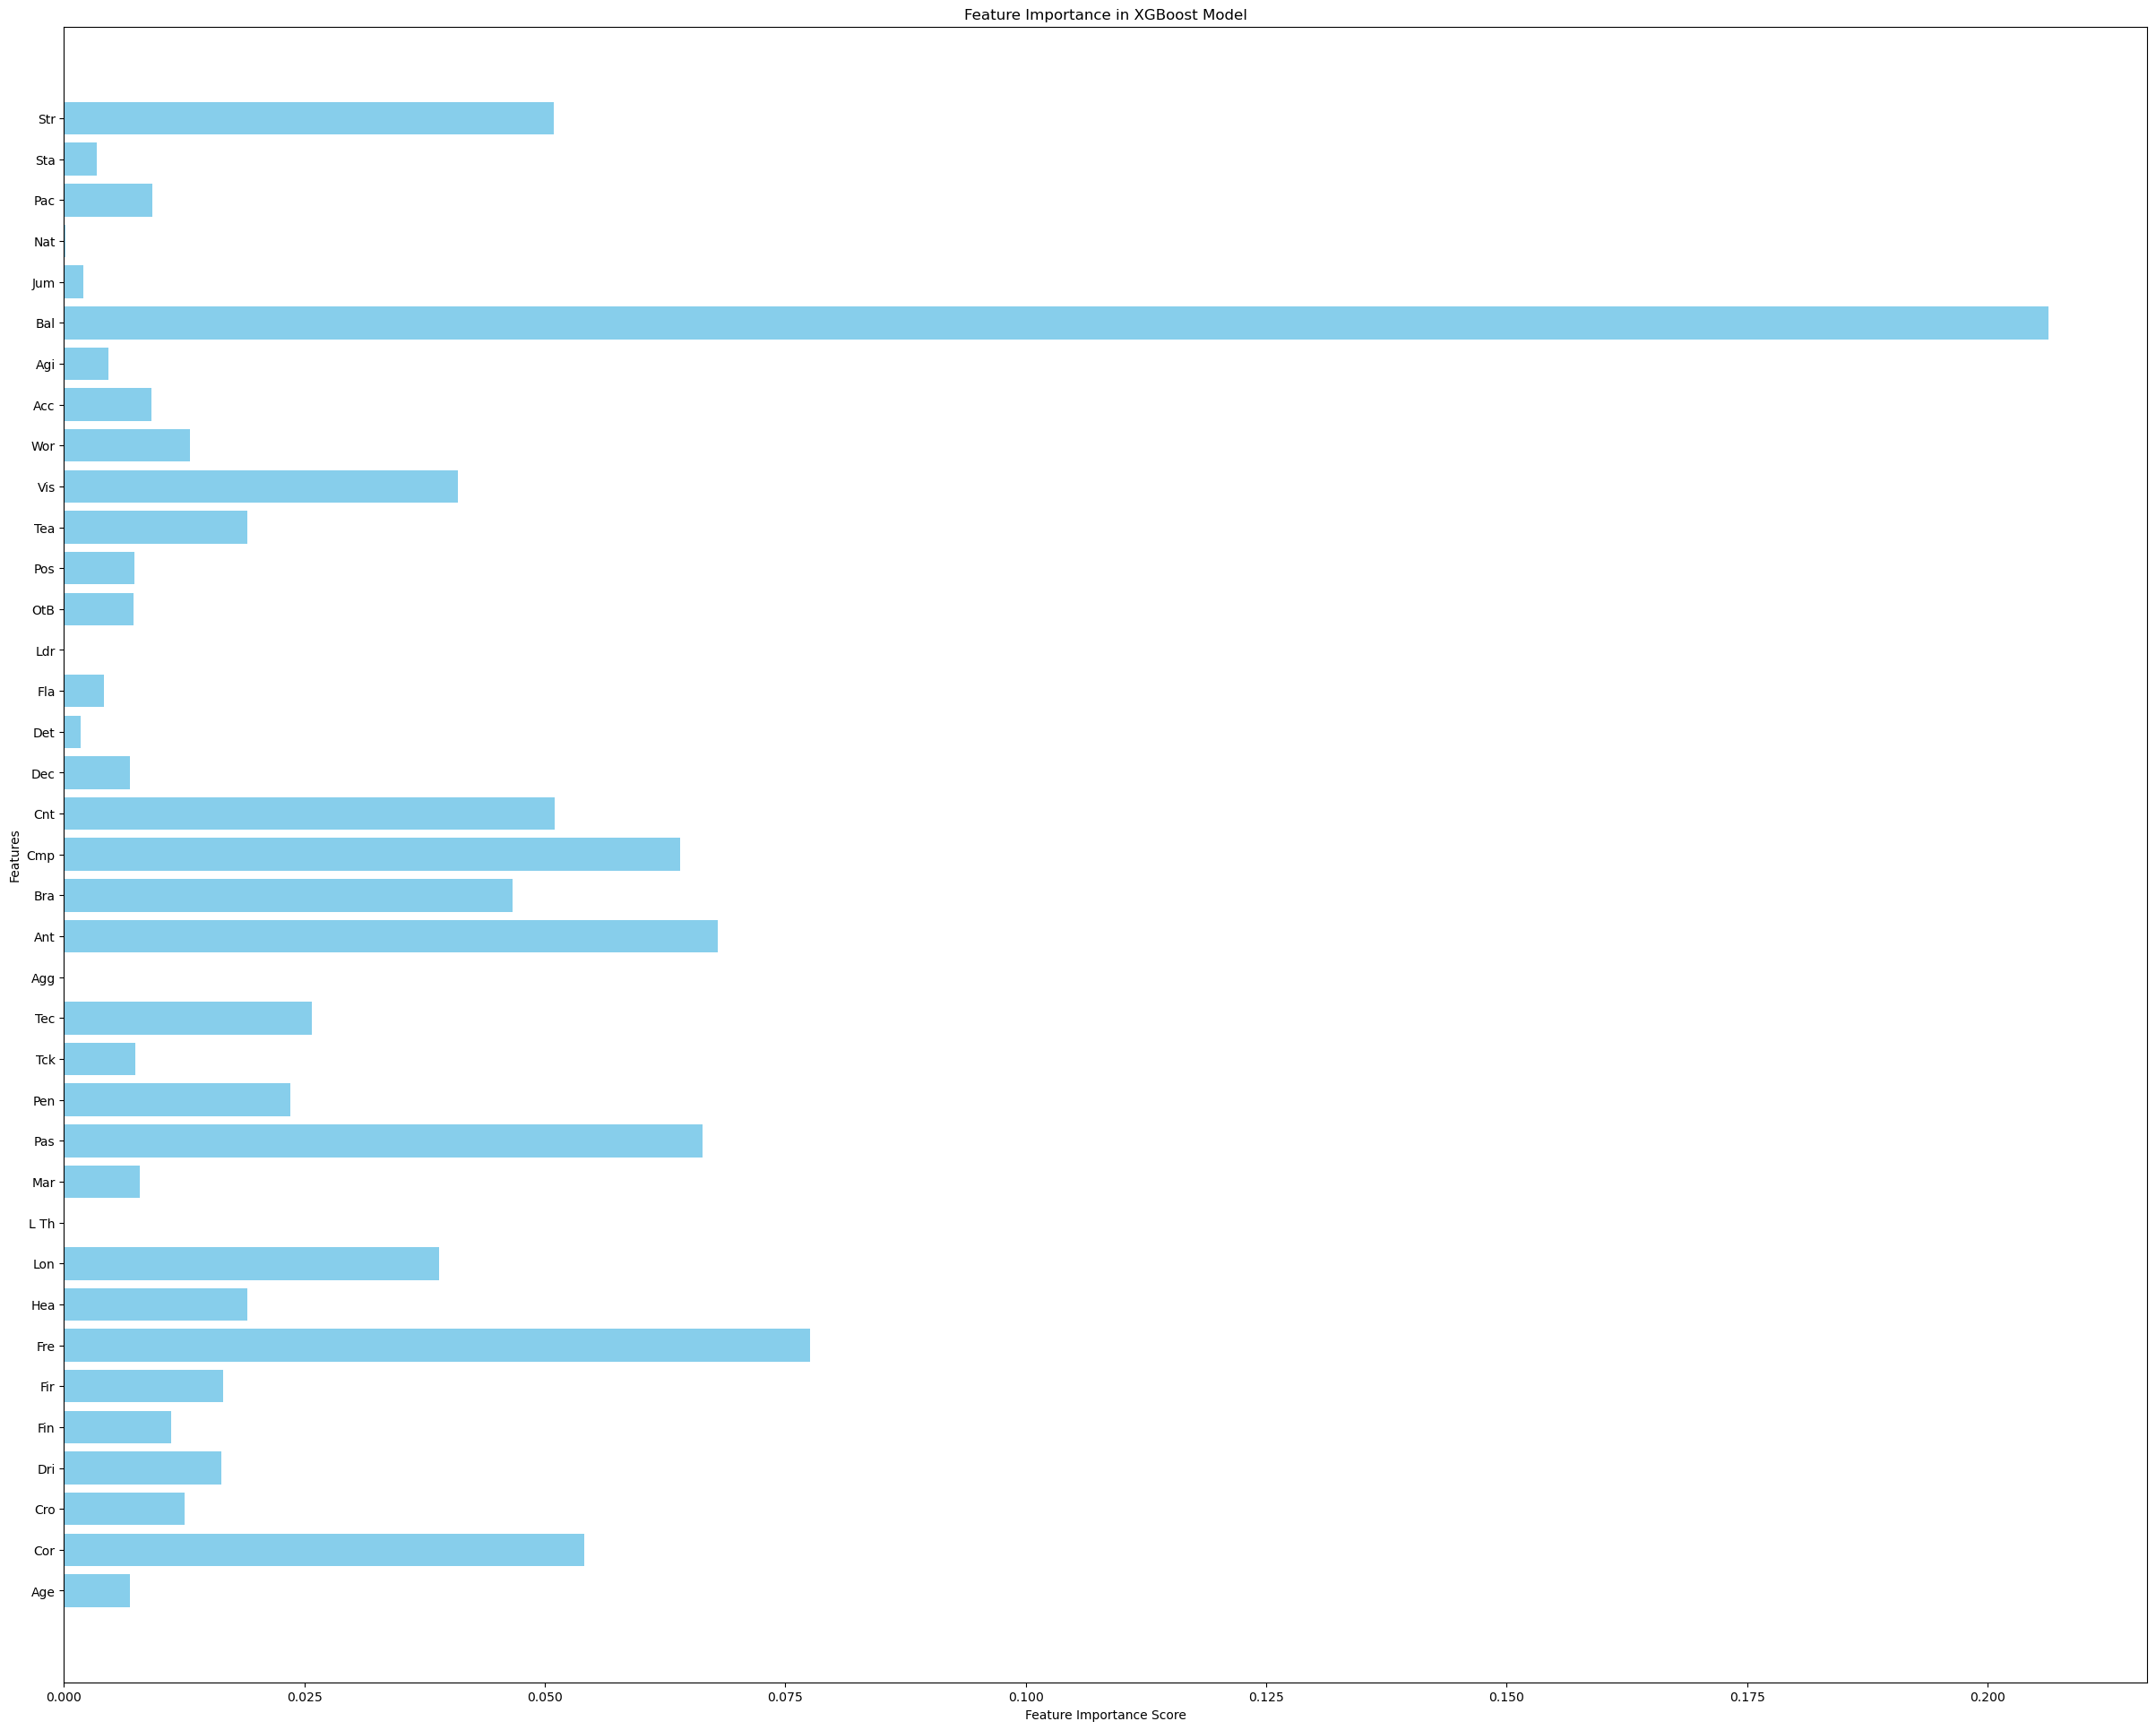

In [203]:
feature_importance = xgb.feature_importances_
feature_names = X.columns

plt.figure(figsize=(30, 24))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.show()

In [204]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(xgb, "xgboost_player_potential.pkl")

['xgboost_player_potential.pkl']

In [205]:
scaler = joblib.load("scaler.pkl")
encoder = joblib.load("encoder.pkl")
xgb = joblib.load("xgboost_player_potential.pkl")

old_features = data.columns
data_new = pd.read_csv("las_palmas_players.csv")
data_new = data_new.drop(data_new.tail(2).index)
names = data_new['Name']
data_new = data_new.drop(columns=['Inf', 'Name'])

data_new = position_mapping(data_new)

# Ensure the new data has all required columns and no extra ones
for col in old_features:
    if col not in data_new.columns:
        data_new[col] = 0  # Add missing column with default value
data_new = data_new[old_features].drop(columns=['PA'])
data_new_scaled = scaler.fit_transform(data_new)
new_preds = xgb.predict(data_new_scaled)

out_df = pd.DataFrame({'Name': names, 'PA':new_preds})
#data_new['Predicted_Potential'] = new_preds
print(out_df)

                Name          PA
0        Owen Alonso   47.421177
1        Carlos Alba   51.195854
2    Christophe Lamy   85.217842
3              Garoé   83.503754
4         Dirk Stolz   83.929878
..               ...         ...
59      Joaquín Simó  118.037628
60  Francisco Moreno  112.327866
61            Javier  109.068222
62   Diego Berenguer  109.317421
63         Brad Hird   97.943741

[64 rows x 2 columns]


Training MAE: 10.80044254545704
New data predictions: [ 47.421177  51.195854  85.21784   83.50375   83.92988   95.02316
 108.20112   78.91648   87.49096   69.5409    64.26464   83.7908
  97.41591   82.539085 106.21525   97.736305  87.42288   88.55025
  98.92763  110.44103  104.563644  83.29758   98.4331    69.71872
  87.23748   90.364105  99.03112   70.31147   73.592094  82.04195
 106.07634  106.85047  106.13266  106.65423   99.18507  101.647514
  89.74893   97.37698   90.79036   94.49637   96.31556   92.49175
 102.3225   107.50106   84.8262   104.44636   83.85578   81.60926
  84.62359  106.530426 102.93089  112.59356  103.452515 106.222565
  88.4633    88.00829   93.51331   98.71061  105.00721  118.03763
 112.327866 109.06822  109.31742   97.94374 ]
1.0001095199562753


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

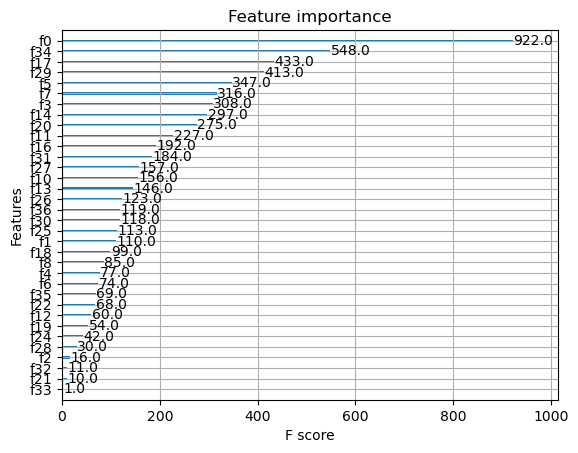

In [209]:
train_predictions = xgb.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, train_predictions))

new_predictions = xgb.predict(scaler.fit_transform(data_new))
print("New data predictions:", new_predictions)

print(X_train.var())

plot_importance(xgb)